In [1]:
import os
import pandas as pd
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import chromosomeDefinition as cd
import analyseVCF as aVCF

In [2]:
CNV_COLUMNS = ['chrom','posStart','posEnd','copyNum','gainOrLoss','BAF','score','germlineOrSomatic','oneOrZero']

In [3]:
# LOAD BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
BED_FILE_NAME = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.bed"
USE_BED = True
LOAD_FULL_FILE = True

In [4]:
# HEALTH CHECKS
HEALTH_CSV_PATH="/Users/peterpriestley/hmf/analyses/healthCheckAnalysis/"
HEALTH_CSV_FILENAME="healthCheckFile.csv"

### FUNCTIONS

In [5]:
def findFiles(path,suffix):
    files=[]
    for x in os.listdir(path):
        if x[-len(suffix):] == suffix:
            files.append(x)
    return files

In [6]:
def loadCNVforPatient(cnvFile,patientName):
    dfCNV = pd.read_table(cnvFile, names = CNV_COLUMNS )
    #add regions with default copy number
    last = dfCNV.iloc[0]
    for i in range(1, dfCNV.shape[0]-1):
        if last['posEnd']<>dfCNV.iloc[i]['posStart']:
            if last['chrom']==dfCNV.iloc[i]['chrom']:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], dfCNV.iloc[i]['posStart']-1,2,'none','','',0,0]
            else:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], cd.chromosomeLength[last['chrom']],2,'none','','',0,0]
                if dfCNV.iloc[i]['posStart']<>0:
                    dfCNV.loc[len(dfCNV)] = [dfCNV.iloc[i]['chrom'],0, dfCNV.iloc[i]['posStart'],2,'none','','',0,0]
        last = dfCNV.iloc[i]
    #fix first record
    if dfCNV.iloc[0]['posStart']<>0:
        dfCNV.loc[len(dfCNV)] = ['1',0, dfCNV.iloc[0]['posStart'],2,'none','','',0,0]
    #Additional Fields
    dfCNV['chromPos']= dfCNV['chrom'].apply(lambda x: cd.intChrom(x)) + dfCNV['posStart'] / dfCNV['chrom'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfCNV['chrom'] = dfCNV['chrom'].apply(lambda x: cd.intChrom(x))
    dfCNV['cappedCopyNum'] = dfCNV['copyNum'].clip(upper=5)
    dfCNV = dfCNV.sort_values(["chrom","posStart","posEnd"]).reset_index()
    dfCNV['regionLength'] = (dfCNV['posEnd']-dfCNV['posStart'])
    dfCNV['patientName']=patientName
    return dfCNV

In [7]:
def calculateMBAFCountBetween(chrom,minPos,maxPos):
   return dfBAF[(dfBAF.Chromosome==chrom)&(dfBAF.Position>minPos)&(dfBAF.Position<maxPos)]['mBAF'].count()

In [8]:
def calculateMBAFBetween(chrom,minPos,maxPos):
   return dfBAF[(dfBAF.Chromosome==chrom)&(dfBAF.Position>minPos)&(dfBAF.Position<maxPos)]['mBAF'].median()

In [9]:
def loadBAFData(bafFile):
    df = pd.read_table(bafFile)
    return df

In [10]:
def loadHealthChecksAndMerge(df):
    hc = pd.read_csv(HEALTH_CSV_PATH + HEALTH_CSV_FILENAME)
    hc = hc[['SAMPLE','TUMOR_PERCENTAGE','TUMOR_TYPE','PIPELINE_VERSION']]
    hc = hc[hc['SAMPLE'].str[12]=="T"]   # only tumor rows
    hc['SAMPLE']=hc['SAMPLE'].str[:12]
    hc = hc.set_index(['SAMPLE'])
    df = pd.merge(df,hc,how='left', left_on='patientName',right_index=True)
    df.fillna("Unknown", inplace=True)
    return df

In [11]:
def cnvChart(dfCNV,filename,minChrom=1,maxChrom=23):
    plt.figure(figsize=[18,3])
    plt.title(filename)
    ax = plt.gca()
    ax.plot(dfCNV['chromPos'], dfCNV['copyNum'],drawstyle="steps-post")
    ax.axis([minChrom, maxChrom, 0, 6])
       

In [12]:
def cnvLabel(copyNumber):
    if copyNumber < 2:
        return 'loss'
    elif copyNumber > 2:
        return 'amplification'
    else:
        return'normal'

In [13]:
def runGeneCNVAnalysis(dfCNV,bed,patientName):
    geneList =[]
    for bedrow in bed:
        bedChromPosStart = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
        bedChromPosEnd = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
        prevCNV = max(dfCNV[(dfCNV['chromPos'] < bedChromPosStart)].index.tolist())
        if dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist():
            nextCNV = min(dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist())
            minCopyNum = min(([dfCNV.iloc[x]['copyNum']]) for x in range (prevCNV,nextCNV)) 
        else:
            minCopyNum = [-1]
        geneList.append([patientName,bedrow[3],bedrow[0],bedrow[1],bedrow[2],minCopyNum[0],cnvLabel(minCopyNum[0])])
    return geneList

In [14]:
def patientIDFromFilename(filename):
    patientIDStart = filename.find("CPCT02")
    return filename[patientIDStart:patientIDStart+12]

In [15]:
def germlineVCFSampleNames(filename,patientID):
    return {patientID+'R':'normal',patientID+'T':'tumor'}

In [16]:
def loadVCF(path,filename,sampleNames,patientID):
    df = pd.DataFrame()
    if USE_BED:
        bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True,True,bed,LOAD_FULL_FILE)])
    else:
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True)])

In [17]:
def AFByPosPlot(pos,AF,startChartPos,endChartPos):
    plt.figure(figsize=[18,5])
    plt.scatter(pos, AF)
    plt.grid(b=True, which='both', color='0.65',linestyle='-')
    plt.axis([startChartPos, endChartPos,0, 1.0])
    plt.show()

In [18]:
def loadPON(aPath,aPONFile):
    myPON = []
    with open(aPath + aPONFile, 'r') as f:
        for line in f:
            line = line.strip('\n')
            splitLine = line.split('\t')
            myPON.append(splitLine)
    dfPON = pd.DataFrame(myPON)
    dfPON.columns = ['chrom','pos','ref','alt','PONCount']
    return dfPON

In [97]:
def findPeaks(log_dens):
    peaks = []
    troughs = []
    dens=np.exp(log_dens)
    diff = [dens[x] - dens[x-1] for x in range(1,len(dens))]
    for i in range (len(diff)-1):
        if diff[i+1] < 0 and diff[i] > 0:
            peaks.append(float(i+1)/len(dens))
        if diff[i+1] > 0 and diff[i] < 0:
            troughs.append(float(i+1)/len(dens))
    return peaks, troughs

### LOAD PON

In [19]:
# Only needs to be run once
dfPON = loadPON("/Users/peterpriestley/hmf/analyses/PON/779filePON/","PON.tsv")

### FIND ALL FILES

In [53]:
PATH = "/Users/peterpriestley/hmf/analyses/v1.12samples/CPCT02040080/"

In [54]:
germlineVCFFilename = findFiles(PATH,"SLICED.vcf")[0]
somaticVCFFilename = findFiles(PATH,"melted.vcf")[0]
patientID = patientIDFromFilename(germlineVCFFilename)
cnvFilename = findFiles(PATH,"gz_CNVs")[0]
print "germline =",germlineVCFFilename
print "somatic =",somaticVCFFilename
print "patient =",patientID
print "CNV =",cnvFilename

germline = 170305_HMFregCPCT_FR13274493_FR10248427_CPCT02040080.annotatedSLICED.vcf
somatic = CPCT02040080R_CPCT02040080T_melted.vcf
patient = CPCT02040080
CNV = CPCT02040080T_dedup.realigned.pileup.gz_CNVs


### LOAD VCFS

In [55]:
#LOAD VCFS
dfGermline = loadVCF(PATH,germlineVCFFilename,{patientID+'R':'normal',patientID+'T':'tumor'},patientID)
dfSomatic = loadVCF(PATH,somaticVCFFilename,{patientID+'T':'melted'},patientID)

reading vcf file: 170305_HMFregCPCT_FR13274493_FR10248427_CPCT02040080.annotatedSLICED.vcf
reading VCF File line: 1
reading VCF File line: 200001
Number variants loaded: 341802
reading vcf file: CPCT02040080R_CPCT02040080T_melted.vcf
reading VCF File line: 1
Number variants loaded: 58048


In [56]:
# APPLY PON to SOMATICs
dfSomatic['alt'] = dfSomatic['meltedallele']
dfSomatic = pd.merge(dfSomatic,dfPON,how='left', on=['chrom','pos','ref','alt'])
dfSomatic['PONCount'].fillna(0, inplace=True)
dfSomatic['inPON'] = pd.to_numeric(dfSomatic.PONCount,errors=coerce)>4

### Load BAF and CNV and calculate median BAF per segment

In [57]:
dfBAF = dfGermline[(dfGermline['variantType']=="SNP")&(dfGermline['normalSGT']=="0/1")&(dfGermline['normalAF']>0.4) \
                   &(dfGermline['normalAF']<0.65)&(dfGermline['normalDP']>30)&\
                   (dfGermline['normalDP']<40)][['chrom','pos','tumorAF']]
dfBAF.columns = ['Chromosome', 'Position','BAF']
dfBAF['Position'] = pd.to_numeric(dfBAF['Position'])
dfBAF['mBAF']= 0.5+abs(dfBAF['BAF']-0.5)
dfBAF['chromPos']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x)) + dfBAF['Position'] / dfBAF['Chromosome'].apply(lambda x: cd.chromosomeLength[str(x)])
dfBAF['Chromosome']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x))
dfBAF.head(1)

,Chromosome,Position,BAF,mBAF,chromPos
16,1,1721479,0.486486,0.513514,1.006907


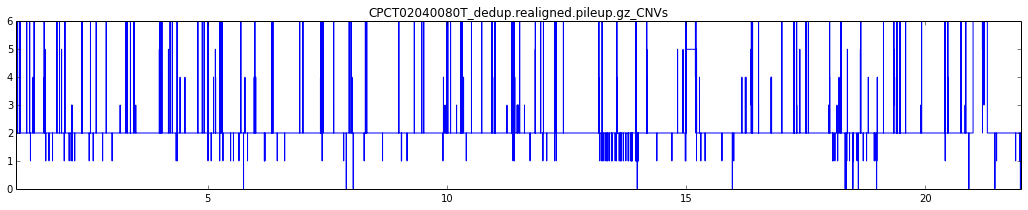

In [58]:
dfCNV = loadCNVforPatient(PATH+cnvFilename,patientID)
dfCNV['mBAF'] = np.vectorize(calculateMBAFBetween)(dfCNV['chrom'], dfCNV['posStart'],dfCNV['posEnd'])
dfCNV['mBAFCount'] = np.vectorize(calculateMBAFCountBetween)(dfCNV['chrom'], dfCNV['posStart'],dfCNV['posEnd'])
cnvChart(dfCNV,cnvFilename,1,22)

### TUMOR PURITY

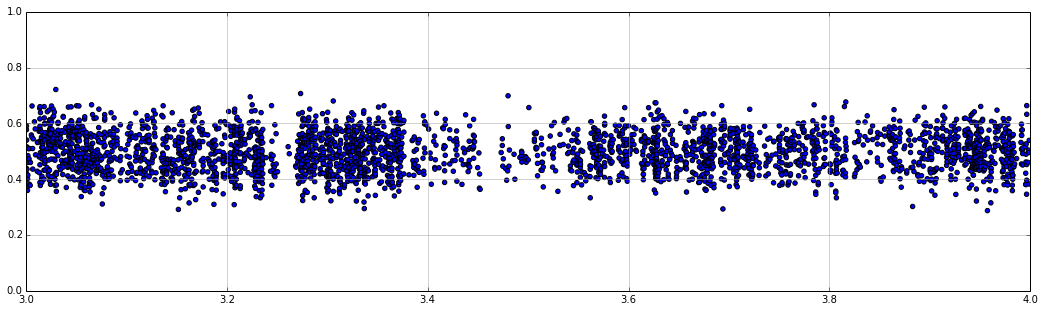

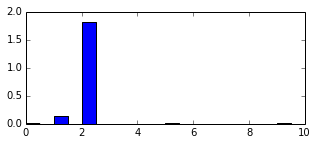

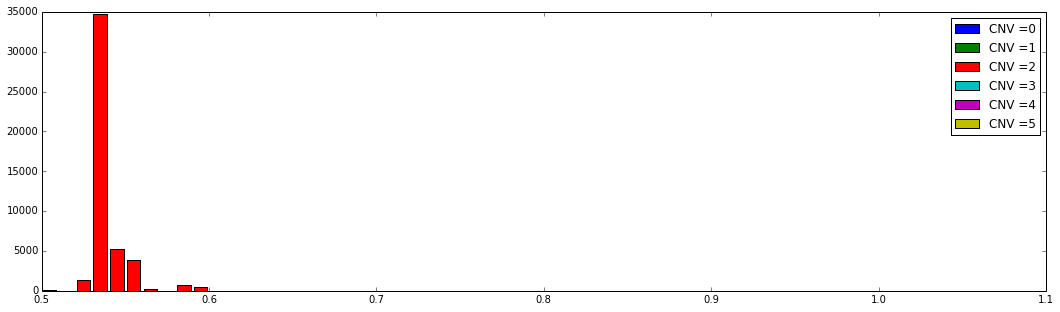

In [150]:
c = 1
fractionMin = 0
fractionMax = 22
dfSom = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
plt.figure(figsize=[18,5])
plt.scatter(dfSom.chromPos, dfSom.BAF)
plt.grid(b=True, which='both', color='0.65',linestyle='-')
plt.axis([c+fractionMin, c+fractionMax,0, 1.0])
plt.show()
# CNV according to freeC
plt.figure(figsize=[5,2])
plt.hist(dfCNV['copyNum'].values,cumulative=False, normed=True, bins=20,range=(0,10),weights=dfCNV['regionLength'].values)
plt.show()
# should only use regions with mbaf > x
c,fractionMin,fractionMax = 1,0,22
dftemp = dfCNV[(dfCNV.mBAF>=0.0)&(dfCNV.mBAF<=1.0)&(dfCNV.mBAFCount>100)&(dfCNV.chromPos<=c+fractionMax)&(dfCNV.chromPos>=c+fractionMin)]
plt.figure(figsize=[18,5])
for CNV in range(0,6):
    plt.hist(dftemp[(dftemp.copyNum==CNV)]['mBAF'].values,cumulative=False, normed=False, bins=50,range=(0.5,1.0),weights=dftemp[(dftemp.copyNum==CNV)]['mBAFCount'].values,stacked = True,rwidth=0.8,label='CNV ='+str(CNV))
    plt.legend()
plt.show()

In [82]:
dfCNV[(dfCNV.copyNum>0)&(dfCNV.mBAF<1.5)&(dfCNV.mBAF>0.57)\
      &(dfCNV.mBAFCount>10)][['chrom','posStart','copyNum','chromPos','regionLength','mBAF','mBAFCount']]

,chrom,posStart,copyNum,chromPos,regionLength,mBAF,mBAFCount
829,16,0,2,16.000000,15049000,0.594340,537
831,16,15059000,2,16.166665,6475999,0.585586,99
835,16,22710000,2,16.251343,3117999,0.580357,69
837,16,25993000,2,16.287677,6186999,0.586207,126
880,17,166000,2,17.002044,20605999,0.582418,403


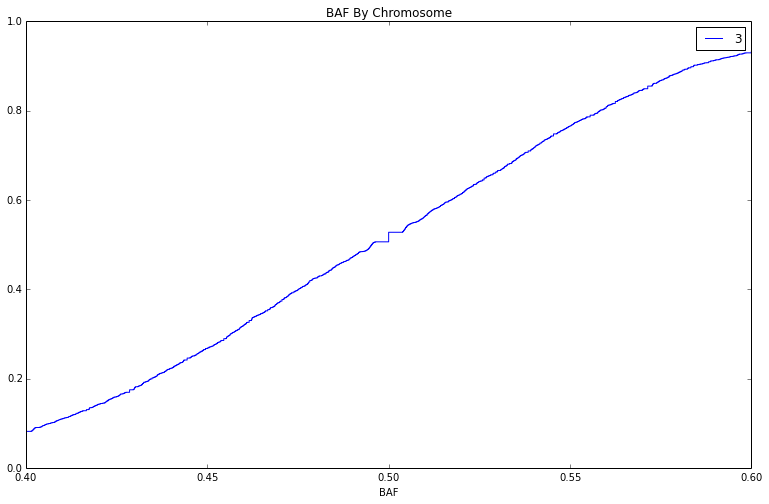

In [152]:
chromosomes = [3]#dfBAF['Chromosome'].unique()
for chromosome in chromosomes:
    ser = dfBAF[dfBAF.Chromosome==chromosome]["BAF"]
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=str(chromosome))
    ser_cdf.plot(drawstyle='steps',legend=True,title="BAF By Chromosome",figsize=[13,8],xlim=[0.4,0.6],ylim=[0,1.0])

In [62]:
dfCNV[(dfCNV.chrom==21)&(dfCNV.mBAFCount>200)][['chrom','posStart','copyNum','chromPos','regionLength','mBAF','mBAFCount']]

,chrom,posStart,copyNum,chromPos,regionLength,mBAF,mBAFCount
1093,21,31186000,2,21.647955,11658999,0.532787,389


### SOMATIC AF

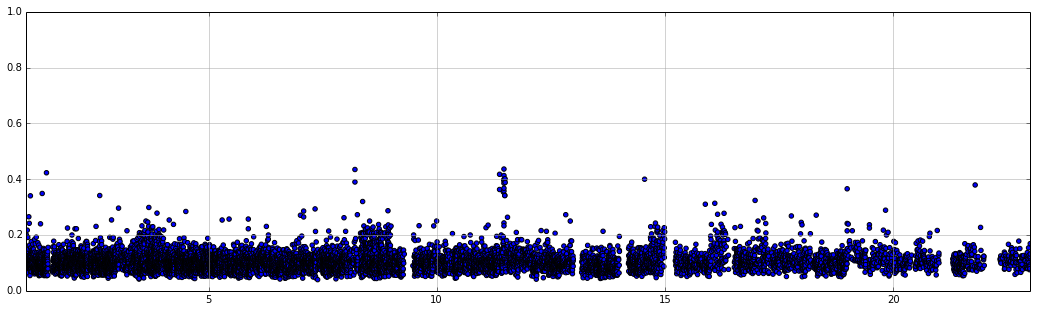

In [129]:
c,fractionMin,fractionMax = 1,0,22
dfSom = dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)&(dfSomatic.chromFrac>c+fractionMin)&(dfSomatic.chromFrac<c+fractionMax)]
AFByPosPlot(dfSom.chromFrac, dfSom.meltedAF,c+fractionMin, c+fractionMax)

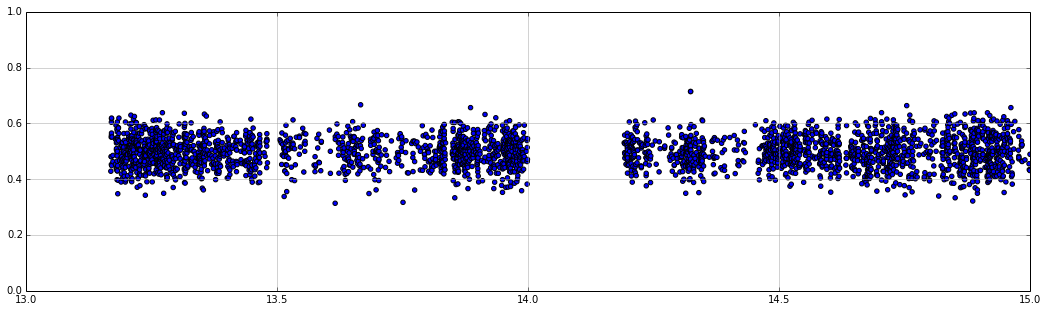

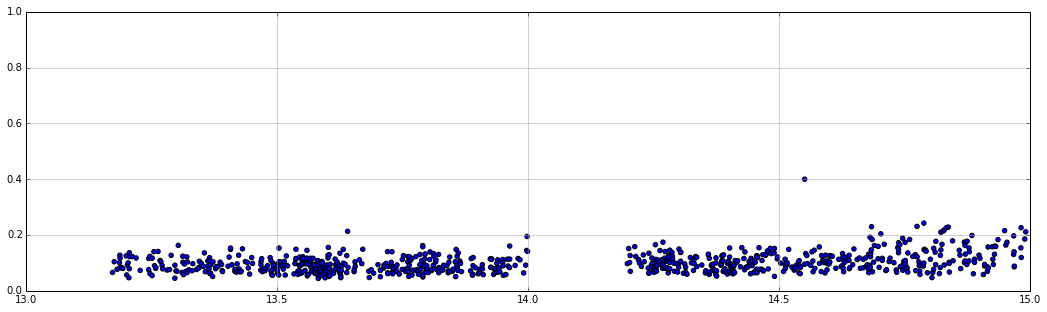

,chrom,posStart,copyNum,chromPos,regionLength,mBAF,mBAFCount
665,13,20372000,2,13.176887,2220999,0.544577,60
667,13,22598000,2,13.196214,5145999,0.537190,158
674,13,28510000,2,13.247547,2527999,0.534653,94
676,13,31040000,2,13.269515,4520999,0.534708,106
678,13,35565000,2,13.308805,3491999,0.540541,63
680,13,39060000,2,13.339151,2177999,0.534487,62
684,13,41976000,2,13.364470,4020999,0.530625,58
688,13,47250000,2,13.410264,3818999,0.536039,44
690,13,51075000,2,13.443475,949999,0.555089,24
692,13,52028000,2,13.451750,7440999,0.535088,59


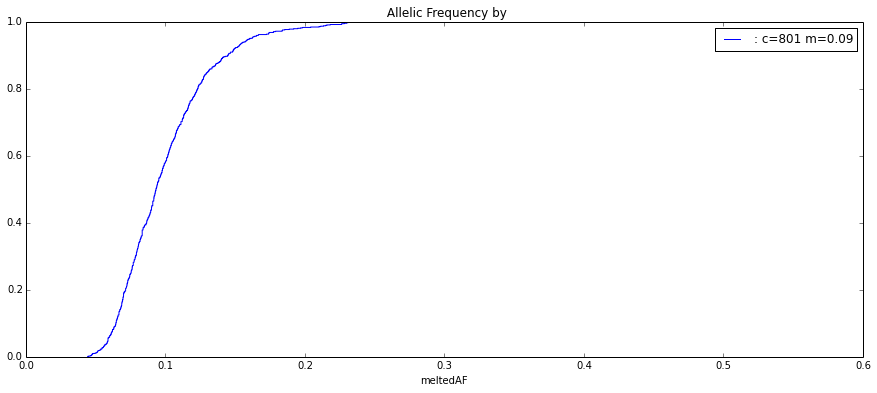

In [146]:
c,fractionMin,fractionMax = 13,0,2
dfTemp = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
AFByPosPlot(dfTemp.chromPos, dfTemp.BAF,c+fractionMin, c+fractionMax)
dfSom = dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)&(dfSomatic.chromFrac>c+fractionMin)&(dfSomatic.chromFrac<c+fractionMax)]
AFByPosPlot(dfSom.chromFrac, dfSom.meltedAF,c+fractionMin, c+fractionMax)

#CDF
ser = dfSom.meltedAF.sort_values()
cum_dist = np.linspace(0.,1.,len(ser))
ser_cdf = pd.Series(cum_dist, index=ser,name=": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by ",figsize=[15,6],xlim=[0.0,0.6])

#mbaf
dfCNV[(dfCNV.chromPos>c+fractionMin)&(dfCNV.chromPos<c+fractionMax)&(dfCNV.mBAFCount>20)][['chrom','posStart','copyNum','chromPos','regionLength','mBAF','mBAFCount']]

### PDF peak fMinding

In [103]:
#dfSom.plot(y='meltedAF', kind='kde', figsize=(10, 6))

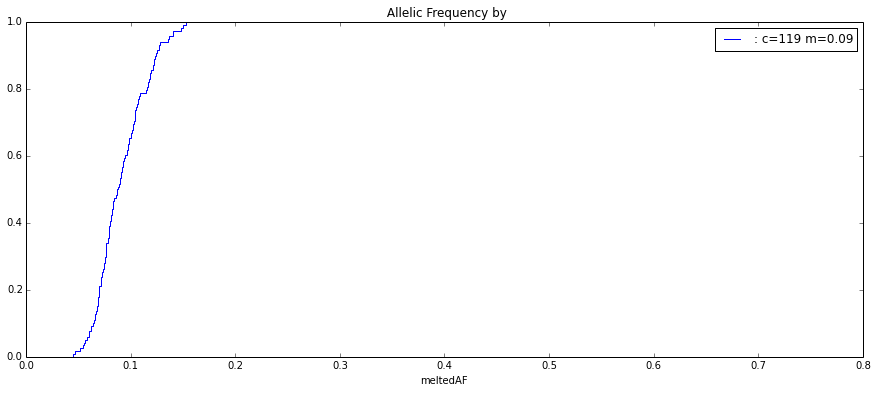

In [147]:
c,fractionMin,fractionMax = 13,0,0.5
dfSom = dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)&(dfSomatic.chromFrac>c+fractionMin)&(dfSomatic.chromFrac<c+fractionMax)]
ser = dfSom.meltedAF.sort_values()
cum_dist = np.linspace(0.,1.,len(ser))
ser_cdf = pd.Series(cum_dist, index=ser,name=": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by ",figsize=[15,6],xlim=[0.0,0.8])


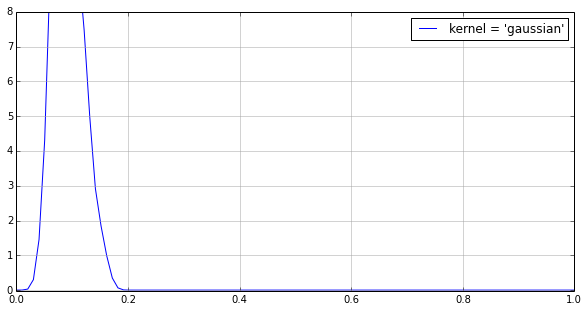

In [148]:
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
X = dfSom.meltedAF.sort_values()[:, np.newaxis]
X_plot = np.linspace(0,1,100)[:, np.newaxis]
fig, ax = plt.subplots()
kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(X)
log_dens = kde.score_samples(X_plot)
ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format('gaussian'))
ax.legend(loc='upper right')
fig.set_figwidth(10)
fig.set_figheight(5)
ax.set_xlim(0, 1)
ax.set_ylim(-0.02, 8)
ax.grid(b=True, which='both', color='0.65',linestyle='-')
plt.show()

In [141]:
findPeaks(log_dens)

([0.09, 0.22, 0.4], [0.2, 0.32])

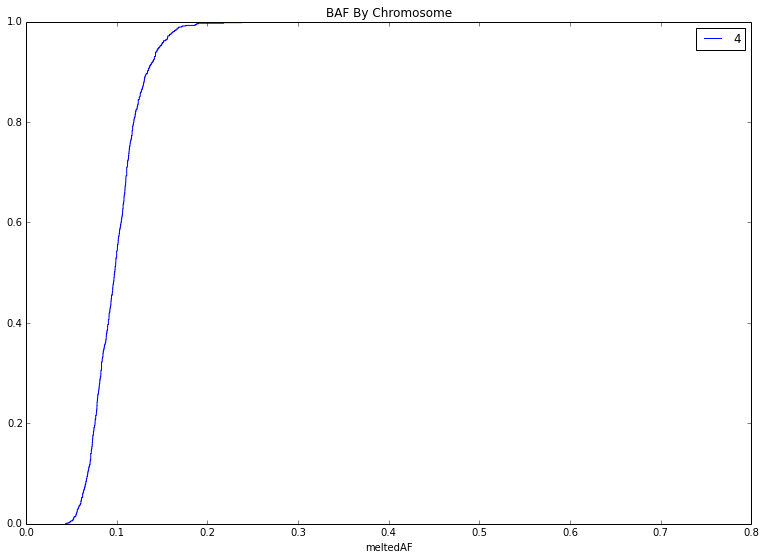

In [102]:
chromosomes = ['4']#dfSomatic['chrom'].unique()
for chromosome in chromosomes:
    try:
        ser = dfSomatic[(dfSomatic.chrom==chromosome)&(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)]["meltedAF"]
        ser = ser.sort_values()
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=str(chromosome))
        ser_cdf.plot(drawstyle='steps',legend=True,title="BAF By Chromosome",figsize=[13,9],xlim=[0.0,0.8],ylim=[0.0,1.0])
    except TypeError:
        continue